# Sinkhorn Barycenters

## Import Toolboxes

This NB was run on Colab using a GPU.

In [ ]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main
    %pip install -q nilearn

In [1]:
import nilearn
from nilearn import datasets, image, plotting
from nilearn.image import get_data

import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

from ott.geometry import costs, epsilon_scheduler, grid
from ott.problems.linear import barycenter_problem as bp
from ott.solvers.linear import discrete_barycenter as db

## Import neuroimaging data using `nilearn`.

We recover a few MRI datapoints...

In [ ]:
n_subjects = 4
dataset_files = datasets.fetch_oasis_vbm(n_subjects=n_subjects)
gm_imgs = np.array(dataset_files.gray_matter_maps)

... and plot their gray matter densities. 

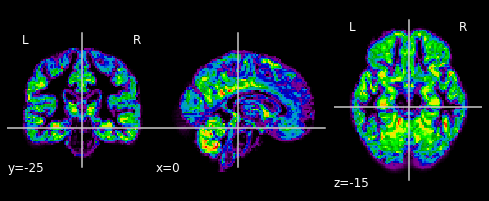

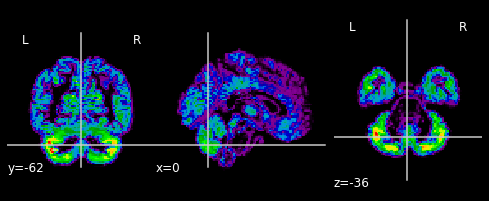

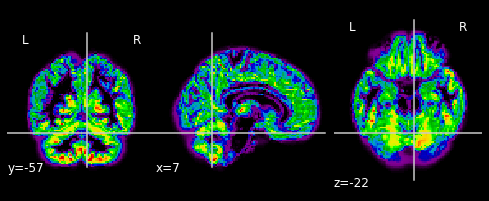

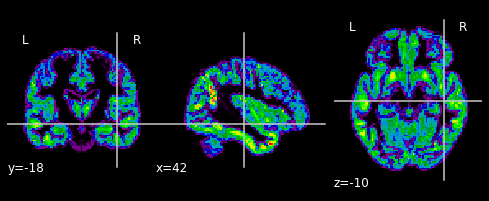

In [ ]:
for i in range(n_subjects):
    plotting.plot_epi(gm_imgs[i])
    plt.show()

## Represent data as histograms

We normalize those gray matter densities so that they sum to $1$, and check their size.

In [ ]:
a = jnp.array(get_data(gm_imgs)).transpose((3, 0, 1, 2))
grid_size = a.shape[1:4]
a = a.reshape((n_subjects, -1)) + 1e-2
a = a / np.sum(a, axis=1)[:, np.newaxis]
print("Grid size: ", grid_size)

Grid size:  (91, 109, 91)


## Instantiate a `grid` geometry to compute $W_p^p$

We instantiate the {class}`~ott.geometry.grid.Grid` geometry corresponding to these data points, living in a space of dimension $91 \times 109 \times 91$, for a total total dimension $d=902629$. Rather than stretch these voxel histograms and put them in the $[0,1]^3$ hypercube, we use a simpler rescaled grid, $[0, 0.9] \times [0, 1.08] \times [0, 0.9]$, with increments of 1/100.

We endow points on that 3D grid with the `Custom` {class}`cost function <ott.geometry.costs.CostFn>` defined below: we use a $p$-norm, with $p$ slighter larger than 1 following previous work of {cite}`gramfort:15` on brain signals.

We use an $\varepsilon$ scheduler that will decrease the regularization strength from 0.1 down to 1e-4 with a decay factor of 0.95.

In [ ]:
@jax.tree_util.register_pytree_node_class
class Custom(costs.CostFn):
    """Custom function."""

    def pairwise(self, x, y):
        return jnp.sum(jnp.abs(x - y) ** 1.1)


# Instantiate Grid Geometry of suitable size, epsilon parameter and cost.
g_grid = grid.Grid(
    x=[jnp.arange(0, n) / 100 for n in grid_size],
    cost_fns=[Custom()],
    epsilon=epsilon_scheduler.Epsilon(target=1e-4, init=1e-1, decay=0.95),
)

## Compute their regularized $W_p^p$ iso-barycenter

A small trick: If we jit and run the {class}`~ott.solvers.linear.discrete_barycenter.FixedBarycenter` function with a small $\varepsilon$ directly, it takes ages because it's both solving a hard problem and jitting the function at the same time. It's slightly more efficient to {func}`jax.jit` it with an easy problem, and run next the problem with the 𝜀 target we need.

In [ ]:
%%time
solver = jax.jit(db.FixedBarycenterProblem())
g_grid._epsilon.target = 1
barycenter = solver(g_grid, a)

CPU times: user 3.8 s, sys: 1.99 s, total: 5.78 s
Wall time: 5.27 s


In [ ]:
%%time
g_grid._epsilon.target = 1e-4
barycenter = solver(bp.FixedBarycenterProblem(g_grid, a))

CPU times: user 7min 16s, sys: 6min 50s, total: 14min 7s
Wall time: 14min 6s


### Plot decrease of marginal error

The computation of the barycenter of $N$ histograms involves the resolution of $N$ OT problems pointing towards the same, but unknown, marginal {cite}`benamou:15`. The convergence of that algorithm can be monitored by evaluating the distance between the marginals of these different transport matrices w.r.t. that same, common marginal. Upon convergence that should be close to $0$.

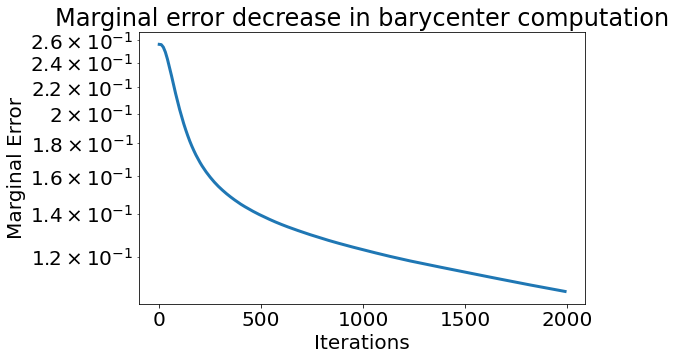

In [ ]:
plt.figure(figsize=(8, 5))
errors = barycenter.errors[:-1]
plt.plot(np.arange(errors.size) * 10, errors, lw=3)
plt.title("Marginal error decrease in barycenter computation")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Marginal Error")
plt.show()

### Plot the barycenter itself

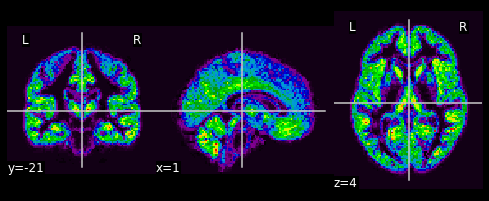

In [ ]:
def data_to_nii(x):
    return nilearn.image.new_img_like(
        gm_imgs[0], data=np.array(x.reshape(grid_size))
    )


plotting.plot_epi(data_to_nii(barycenter.histogram))
plt.show()

### SqEuclidean barycenter, for reference

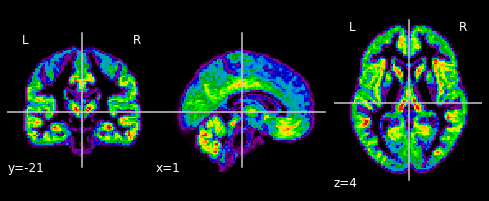

In [ ]:
plotting.plot_epi(data_to_nii(np.mean(a, axis=0)))